<a href="https://colab.research.google.com/github/tronghieu2810/DEEP-LEARNING/blob/main/UDEMY/%5BMike_X_Cohen%5D_Deep_understanding/CNN/DUDL_CNN_codeChallengeBeatThis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
from sklearn.model_selection import train_test_split

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import TensorDataset,DataLoader

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Import and inspect the data

In [3]:
# Download the dataset
cdata = torchvision.datasets.EMNIST(root='emnist', split='letters', download=True)

# Transform to 4D tensor for conv layer (and transform from int8 to float)
images = cdata.data.view([124800, 1, 28, 28]).float()

# Eliminate the N/A and subtract 1 from the original
# Remove the first class category
letter_categories = cdata.classes[1:]
# Relabel labels to start at 0
labels = copy.deepcopy(cdata.targets) - 1

# Normalize the images
images /= torch.max(images)

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting emnist/EMNIST/raw/gzip.zip to emnist/EMNIST/raw


# Create train/test groups using DataLoader

In [6]:
# Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=0.05)

# Convert into PyTorch Datasets
train_data_set = TensorDataset(train_data, train_labels)
test_data_set  = TensorDataset(test_data,  test_labels)

# Translate into Dataloader objects
batch_size   = 32
train_loader = DataLoader(dataset=train_data_set, batch_size=batch_size,
                        shuffle=True, drop_last=True)
test_loader  = DataLoader(dataset=test_data_set, 
                        batch_size=test_data_set.tensors[0].shape[0])

# Create the DL model

In [8]:
def make_the_net(print_toggle=False):
    """
    CNN_ HOW_LOW
    """
    class emnist_net(nn.Module):
        def __init__(self, print_toggle):
            super().__init__()

            self.print = print_toggle

            ######################## FEATURE MAP LAYERS ########################
            self.conv1  = nn.Conv2d(1, 64, kernel_size=3, padding=1)
            self.bnorm1 = nn.BatchNorm2d(num_features=64)
                # (28 + 2*1 - 3)/1 + 1 = 28/2 = 14
            
            self.conv2  = nn.Conv2d(64, 128, kernel_size=3)
            self.bnorm2 = nn.BatchNorm2d(num_features=128)
                # (14 + 2*0 - 3)/1 + 1 = 12/2 = 6
            
            self.conv3  = nn.Conv2d(128, 256, kernel_size=3)
            self.bnorm3 = nn.BatchNorm2d(num_features=256)
                # (6 + 2*0 - 3)/1 + 1 = 4/2 = 2

            ######################## LINEAR DECISION LAYERS ####################
            self.fc1 = nn.Linear(2 * 2 * 256, 256)
            self.fc2 = nn.Linear(256, 64)
            self.fc3 = nn.Linear(64, 26)

        
        def forward(self, x):
            # Convolution -> Maxpool -> Batchnorm -> Relu
            if self.print:    print(f'Input:            {list(x.shape)}')

            x = F.max_pool2d(self.conv1(x), 2)
            x = F.leaky_relu(self.bnorm1(x))
            x = F.dropout(input=x, p=0.25, training=self.training)
            if self.print:    print(f'First CPR Block:  {list(x.shape)}')

            x = F.max_pool2d(self.conv2(x), 2)
            x = F.leaky_relu(self.bnorm2(x))
            x = F.dropout(input=x, p=0.25, training=self.training)
            if self.print:    print(f'Second CPR Block: {list(x.shape)}')

            x = F.max_pool2d(self.conv3(x), 2)
            x = F.leaky_relu(self.bnorm3(x))
            x = F.dropout(input=x, p=0.25, training=self.training)
            if self.print:    print(f'Third CPR Block:  {list(x.shape)}')

            # Reshape for linear layer
            n_units = x.shape.numel() / x.shape[0]
            x       = x.view(-1, int(n_units))
            x = F.dropout(input=x, p=0.25, training=self.training)
            if self.print:    print(f'Vectorized:       {list(x.shape)}')

            # Linear layer
            x = F.leaky_relu(self.fc1(x))
            x = F.dropout(input=x, p=0.5, training=self.training)
            x = self.fc2(x)
            x = F.dropout(input=x, p=0.5, training=self.training)
            x = self.fc3(x)
            if self.print:    print(f'Final output:     {list(x.shape)}')

            return x
    
    # Create the model instance
    net = emnist_net(print_toggle)

    # Loss Function
    loss_func = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, loss_func, optimizer

In [9]:
# Test the model with one batch
net, loss_func, optimizer = make_the_net(print_toggle=True)

X, y = iter(train_loader).next()
y_hat = net(X)

print(''), print(f'Output size: {y_hat.shape}')

loss = loss_func(y_hat, torch.squeeze(y))
print(''), print(f'Loss: {loss}')

Input:            [32, 1, 28, 28]
First CPR Block:  [32, 64, 14, 14]
Second CPR Block: [32, 128, 6, 6]
Third CPR Block:  [32, 256, 2, 2]
Vectorized:       [32, 1024]
Final output:     [32, 26]

Output size: torch.Size([32, 26])

Loss: 3.341740369796753


(None, None)

# Create a function that trains the model

In [10]:
def train_the_model():
    """
    CNN_EMNIST|HOW_LOW
    """
    
    num_epochs = 10

    # Create a new model
    net, loss_func, optimizer = make_the_net()

    # Initialize
    train_loss = torch.zeros(num_epochs)
    test_loss  = torch.zeros(num_epochs)
    train_err  = torch.zeros(num_epochs)
    test_err   = torch.zeros(num_epochs)

    # Send the model to the GPU
    net.to(device)

    # Loop over epochs
    for epoch_i in range(num_epochs):
        net.train()

        # Loop over training data batches
        batch_err  = []
        batch_loss = [] 

        for X, y in train_loader:

            # Push data to GPU
            X = X.to(device)
            y = y.to(device)

            # Forward pass and loss
            y_hat = net(X)
            loss  = loss_func(y_hat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss and Error from this batch
            batch_loss.append(loss.item())
            batch_err .append(torch.mean((torch.argmax(y_hat, axis=1) != y).float()).item())

        # End of batch loop.

        # Get the average training accuracy of the batches
        train_loss[epoch_i] = np.mean(batch_loss)
        train_err [epoch_i] = 100 * np.mean(batch_err)

        # Test accuracy
        net.eval()
        X, y = next(iter(test_loader)) # Extract X, y from dataloader
        
        # Push data to GPU
        X = X.to(device)
        y = y.to(device)

        with torch.no_grad():
            y_hat = net(X)
            loss  = loss_func(y_hat, y)
            
        test_loss[epoch_i] = loss.item()
        test_err     [epoch_i] = 100 * torch.mean((torch.argmax(y_hat, axis=1) != y).float()).item()

    # End epochs

    return train_loss, test_loss, train_err, test_err, net

# Run the model and show the results!

In [11]:
# ~4 minutes with 10 epochs on GPU
train_loss, test_loss, train_err, test_err, net = train_the_model()

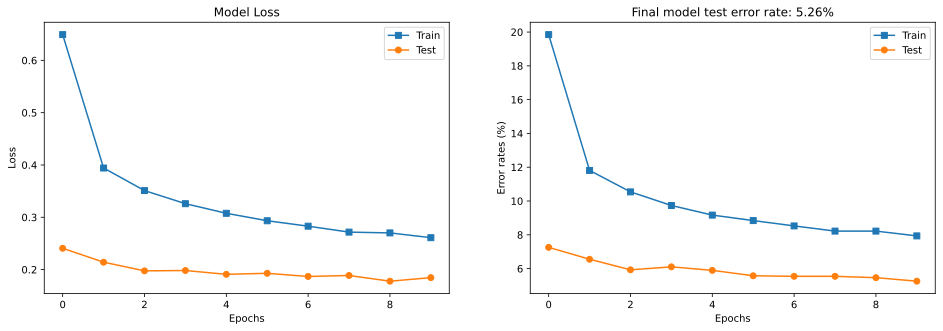

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(train_loss, 's-', label='Train')
ax[0].plot(test_loss,  'o-', label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')
ax[0].legend()

ax[1].plot(train_err, 's-', label='Train')
ax[1].plot(test_err,  'o-', label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {test_err[-1]:.2f}%')
ax[1].legend()

plt.show()